In [2]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

In [3]:
"""导入数据"""
def load_data(path):
    data = np.loadtxt(path)
    data = pd.DataFrame(data)
    return data

In [4]:
"""计算kernel(x_m,x_n),此处的kernel是rbf with gamma 80"""
def compute_Kernel(x_m,x_n):
    return math.exp(-80 * np.dot((x_m - x_n),(x_m - x_n)))

注意，在高斯核中没有weights，因为weights是无限维的。

但我们总可以算出$wTw$, because it equals to $\sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m y_n y_m K(x_n,x_m) $

In [5]:
def compute_weights(clf):
    coef = clf.dual_coef_[0]
    sum_ = 0
    for i in range(len(coef)):
        for j in range(len(coef)):
            sum_ += coef[i] * coef[j] * compute_Kernel(clf.support_vectors_[i],clf.support_vectors_[j])
    
    return np.sqrt(sum_)

In [6]:
def compute_bias(clf):
    # 找出support vector (x_s,y_s)，y_s(wTz_s + b) = 1.
    xs = clf.support_vectors_[0]
    ys = y[clf.support_]
    x = clf.support_vectors_
    # 这里是poly kernel
    term2 = (np.dot(x,xs) + 1) ** 2
    term1 = clf.dual_coef_
    b = ys - np.dot(term1,term2)
    return b

In [7]:
def plot(X,y,clf=None,is_support=0):
    plt.scatter(X[:,0],X[:,1],c=y,s=30,cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0],xlim[1],30)
    yy = np.linspace(ylim[0],ylim[1],30)
    XX,YY = np.meshgrid(xx,yy)
    xy = np.vstack([XX.ravel(),YY.ravel()]).T #vstack垂直方向
    if clf != None:
        Z = clf.decision_function(xy).reshape(XX.shape)
        ax.contour(XX,YY,Z, colors='k',levels=[-1,0,1],alpha=0.5,linestyles=['--','-','--'])
        #这里的level是指函数间隔，我们可以选择不同的函数间隔进行可视化
        #alpha是粗细
        # 支撑向量
        if is_support:
            ax.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1],s=600,linewidth=1,facecolors='none',edgecolors='y')
    plt.show()

In [8]:
def data_form(label=0):
    D = load_data('features.train.txt')
    # intensity, symmetry
    X = np.column_stack([D[1],D[2]]).astype('float') # 一定要是float格式才可以
    y = D[0].copy()
    y[D[0] == label] = 1
    y[D[0] != label] = 0
    y = y.values

    D_test = load_data("features.test.txt")  ##读取数据
    X_test = np.column_stack([D_test[1],D_test[2]]).astype('float') # 一定要是float格式才可以
    y_test = D_test[0].copy()
    y_test[D_test[0] == label] = 1
    y_test[D_test[0] != label] = 0
    y_test = y_test.values
    return X,y,X_test,y_test

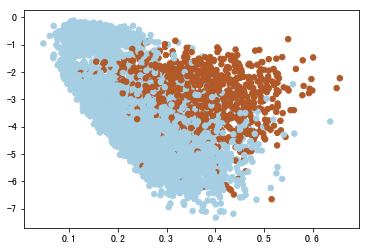

In [9]:
X,y,X_test,y_test = data_form(label = 0)
plot(X,y)

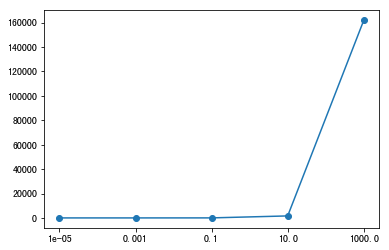

In [10]:
# Q11:
X,y,X_test,y_test = data_form(label = 0)
c = np.array([0.00001, 0.001, 0.1, 10, 1000])
length = np.zeros(len(c))
for i in range(len(c)):
    clf = svm.SVC(C=c[i],kernel='linear')
    clf.fit(X,y)
    length[i] = compute_weights(clf)
out = np.c_[c,length]

plt.plot(out[:,0].astype(str),out[:,1],'-o')
plt.show()

当C增大，对错误对容忍度降低，则margin降低（free sv到边界的距离减小）。同时，更难地去找到长度最短的w，所以optimal w的长度增大。

1e-05 0.001 0.1 10.0 1000.0 

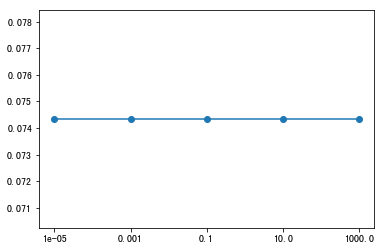

In [11]:
# Q12:
X,y,X_test,y_test = data_form(label = 8)
c = np.array([0.00001, 0.001, 0.1, 10, 1000])
e_in = np.zeros(len(c))
for i in range(len(c)):
    print(c[i],end=" ")
    clf = svm.SVC(C=c[i],kernel='poly',degree=2,gamma=1,coef0=1)
    clf.fit(X,y)
    e_in[i] = np.mean(y != clf.predict(X))
out = np.c_[c,e_in]

plt.plot(out[:,0].astype(str),out[:,1],'-o')
plt.show()

C越大，model训练的速度越慢。因为model需要在【0，C】的范围内去找最优的alpha。

seems that C 的改变并没有改变最优的model，因此也没有改变e_in. 这意味着，最优的model的alpha是落在0.00001以内的。

update：
这种现象很奇特，原来是因为原本的样本非常unbalanced, y是0的样本占了83%。所以当model什么都不做，直接预测0，都有83%的正确率。

1e-05 0.001 0.1 10.0 1000.0 

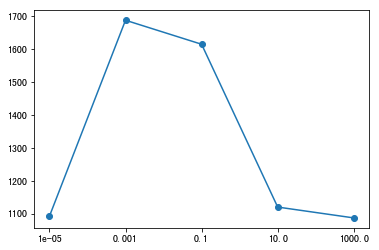

In [12]:
# Q13:
X,y,X_test,y_test = data_form(label = 8)
c = np.array([0.00001, 0.001, 0.1, 10, 1000])
n_sup = np.zeros(len(c))
for i in range(len(c)):
    print(c[i],end=" ")
    clf = svm.SVC(C=c[i],kernel='poly',degree=2,gamma=1,coef0=1)
    clf.fit(X,y)
    n_sup[i] = len(clf.support_)
out = np.c_[c,n_sup]

plt.plot(out[:,0].astype(str),out[:,1],'-o')
plt.show()

Decision boundary的法向量是$w$。

所以距离为 w / ||w || * (z - z') where wz' = - b

So distance = $ |\frac{1}{||w||} * ( w*z + b)|  = |\frac{1}{||w||} * y_n(1-\epsilon_n)| = |\frac{1}{||w||} * (1-\epsilon_n)| $

所以，对于free support vector，它的$\epsilon_n$ = 0, so its distance to the decision boundary is always $ \frac{1}{||w||} $.

当C越大，$ ||w||$ 越大，因此margin越小。

0.001 0.01 0.1 1.0 10.0 

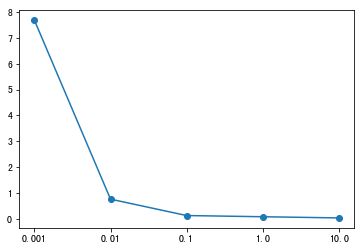

In [13]:
# Q14:
X,y,X_test,y_test = data_form(label = 0)
c = np.array([0.001, 0.01, 0.1, 1, 10])
# c = np.array([0.001])
distance = np.zeros(len(c),)
for i in range(len(c)):
    print(c[i],end=" ")
    clf = svm.SVC(C=c[i],kernel='rbf',gamma=80)
    clf.fit(X,y)
#     plot(X,clf.predict(X),clf,0) 看图，发现样本unbalanced，当C很小的时候，错误容忍度太大。
    # so for free vectors, \epsilon_n = 0, so distance = 1/||w|| 
    distance[i] = 1/compute_weights(clf)

out = np.c_[c,distance]

plt.plot(out[:,0].astype(str),out[:,1],'-o')
plt.show()

1 

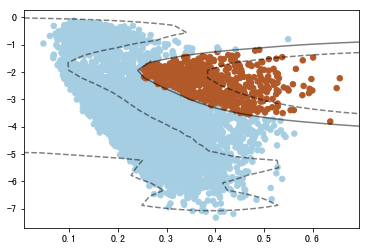

10 

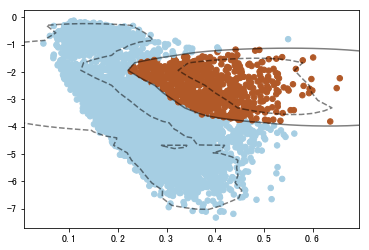

100 

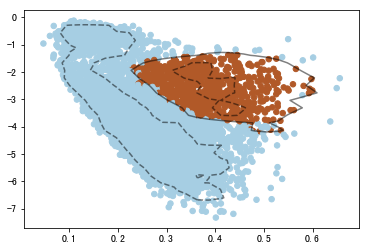

1000 

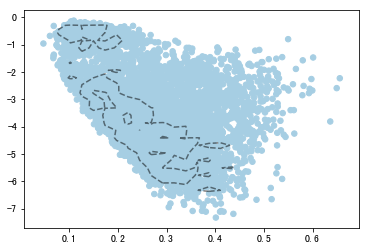

10000 

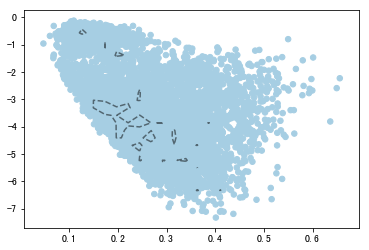

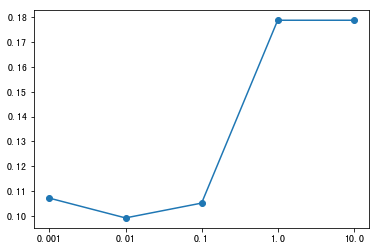

In [14]:
# Q15:
X,y,X_test,y_test = data_form(label = 0)
gamma = np.array([1,10,100,1000,10000])
e_out = np.zeros(len(c),)
for i in range(len(gamma)):
    print(gamma[i],end=" ")
    clf = svm.SVC(C=0.1,kernel='rbf',gamma=gamma[i])
    clf.fit(X,y)
    plot(X,clf.predict(X),clf,0) # 看图，发现样本unbalanced，当C很小的时候，错误容忍度太大。
    e_out[i] = np.mean(y_test != clf.predict(X_test))

out = np.c_[c,e_out]

plt.plot(out[:,0].astype(str),out[:,1],'-o')
plt.show()

随着gamma的增加，高斯核的方差越来越小，即它的形状变得更尖。那么更容易出现各自为政的情况，overfiting。

In [15]:
from sklearn.model_selection import train_test_split

def split_dataset(X,y,num):
    Data = np.c_[X,y]
    train_set, val_set = train_test_split(Data, test_size=0.2)
    #取特征
    X_train = train_set[:, :2]
    #取标签
    y_train = train_set[:, 2]
    X_val = val_set[:, :2]
    y_val = val_set[:, 2]
    return X_train,y_train,X_val,y_val

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

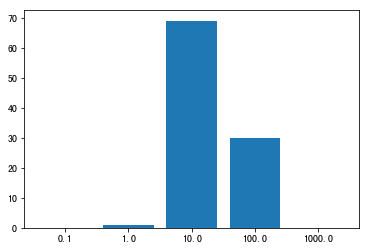

In [18]:
# Q16:
N = 100
gamma = np.array([0.1,1,10,100,1000])
counts = np.zeros(len(gamma),)
for time in range(N): # experiment times
    print(time,end=' ')
    X,y,X_test,y_test = data_form(label = 0)
    X_train,y_train,X_val,y_val = split_dataset(X,y,1000) # each time, resplit the dataset
    e_val = np.zeros(len(gamma),)
    for i in range(len(gamma)):
#         print(gamma[i],end=" ")
        clf = svm.SVC(C=0.1,kernel='rbf',gamma=gamma[i])
        clf.fit(X_train,y_train)
        e_val[i] = np.mean(y_val != clf.predict(X_val))

    counts[np.argmin(e_val)] += 1

plt.bar(gamma.astype(str),counts)
plt.show()

被选择的次数最多的是gamma = 10. 